In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from mlxtend.evaluate import plot_decision_regions

%matplotlib inline

# Perceptron

In [36]:
class Perceptron(object):
    
    def __init__(self, eta=.01, n_iter=10, random=False, seed=1):
        
        self.eta = eta
        self.n_iter = n_iter
        self.random = random
        self.seed = seed
        
    def fit(self, X, y):
        
        # adding x0
        X = np.c_[np.ones(X.shape[0]), X]
        
        if self.random:
            
            np.random.seed(self.seed)
            self.w_ = np.random.random(X.shape[1])
        else:
            
            self.w_ = np.zeros(X.shape[1])

        self.errors_ = []
        
        for _ in range(self.n_iter):
            
            errors = 0
            for xi, target in zip(X, y):
                
                update = self.eta * (target - self.__predict(xi))
                self.w_ += update * xi
                errors += int(update != 0.0)
            
            self.errors_.append(errors)
            
        return self
    
    def net_input(self, X):
        
        return np.dot(X, self.w_)
    
    def __predict(self, X):
        
        return np.where(self.net_input(X) >= 0.0, 1, -1)
    
    def predict(self, X):
        
        X = np.c_[np.ones(X.shape[0]), X]
        
        return self.__predict(X)

# Iris dataset

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

In [4]:
y = df.iloc[:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[:100, [0, 2]].values

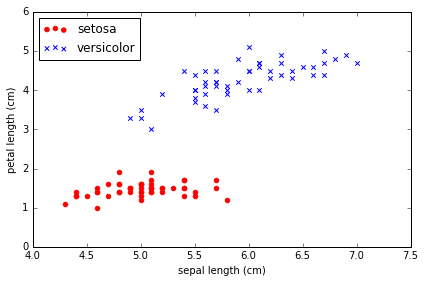

In [6]:
plt.scatter(X[:50, 0], X[:50, 1], color='r', marker='o', label='setosa')
plt.scatter(X[50:, 0], X[50:, 1], color='b', marker='x', label='versicolor')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')
plt.legend(loc='upper left')
plt.tight_layout()

# Perceptron(iris)

### w = ones

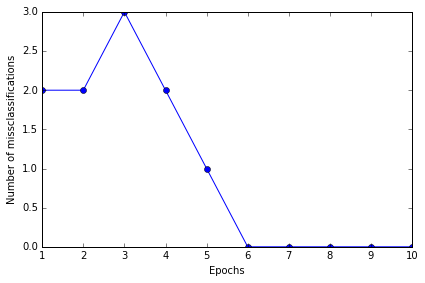

In [38]:
p_ones = Perceptron(eta=.1, n_iter=10)
p_ones.fit(X, y)

plt.plot(range(1, len(p_ones.errors_) + 1), p_ones.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of missclassifications')
plt.tight_layout()

### w = random

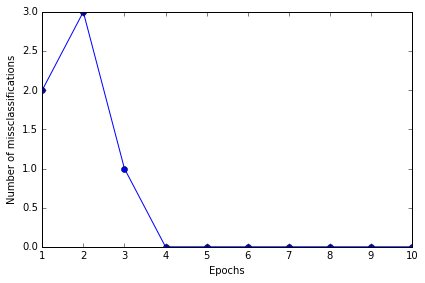

In [39]:
p_rand = Perceptron(eta=.1, n_iter=10, random=True, seed=5)
p_rand.fit(X, y)

plt.plot(range(1, len(p_rand.errors_) + 1), p_rand.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of missclassifications')
plt.tight_layout()

# Ploting decision regions

array([-0.4 , -0.68,  1.82])

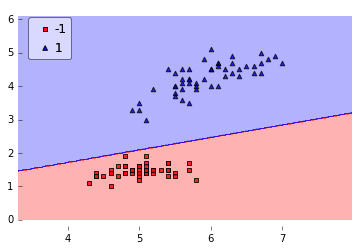

In [42]:
plot_decision_regions(X, y, p_ones, legend=2)
p_ones.w_

array([-0.17800683, -0.36926769,  0.96671916])

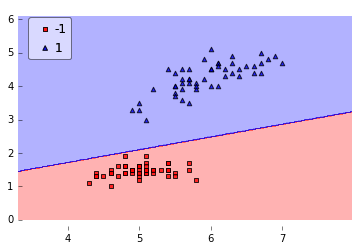

In [43]:
plot_decision_regions(X, y, p_rand, legend=2)
p_rand.w_